<a href="https://colab.research.google.com/github/PedroAdair/News_country/blob/main/Tarea3_PedroAdairGallegosAvila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Centro de Investigación en Matemáticas a.c
## Unidad Monterrey
### Temas Selectos de Ciencia de Datos, tarea 3
#### Pedro Adair Gallegos Avila

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Problema 1: Sobre la las CNN

1.    Dados  los  siguientes  parámetros  para  algún  eje  (canal)  de  un  tensor:

*    $i$:   tamaño  de  los  datos  de  entrada  (cuadradas:   $i1   =  i2   =  i$)
*    $k$:   tamaño  de  un  kernel  de  convolución  cuadrado
*    $s$:   tamaño  de  stride  (igual  en  ambas  direcciones)
*    $p$:   zero  padding  (igual  en  ambas  direcciones)
obtén  una  expresión  para  calcular:

Obener una expresion para calcular:



1.   Tamaño de la salida del mapeo luego de realizar una convolución
2.   Tamaño de salida del proceso de pooling

Para lo siguiente, se toman los resultados extraidos de [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

Consideremos  el salto (stride) $s$, entonces tenemos que en cada vez que se realiza una convolucion comienza en la posicion $-p$ (el padding a la izquierda)y va de $(-p,k-p)$, luego realiza el salto (s) hacia $-p+s$ para realizar una nueva convolución. Tenemos que en total hay
$ (i-k) +2p +1 $  donde el primer sumanod corresponde al numero de convoluciones en el input de la imagen (sin los zero padding) luego se tienen las convoluciones que se realizaron en las orillas de la imagen, mientras que el 1 corresponde al momento de realizar la primer convolución sobre la imagen.

Si realizamos los saltos de tamaño $s$ , tenemos que en total se realizan $$\lfloor \frac{i-k}{s}\rfloor +1$$ convoluciones sobre la primer "fila" antes de bajar a la siguiente (respetando el salto correspondiente ahora hacia abajo).

Para la capa de pooling, tenemos que
$$o= \lfloor \frac{i-k}{s}\rfloor +1 $$

#Problema 2:  Clasificador de noticias por país  basado en CNN

Consideramos  nuevamente   el  corpus  *hispablogs.zip* que  usamos para   la  tarea  2. El objetivo ahora es implementar un clasificador basado en redes convolucionales.

Descargamos las librerias que usaremos a lo largo de este y los siguientes ejercicios

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import torch

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
"""
NLKT es la opción que selecciones para preprocesar mis textos
"""
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#Para stop words en español
es_stop = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


El primer paso consiste en descargar nuestro conjunto de datos en train/test. Para ello usaremos las funciones proporcionadas por el profesor.

In [ ]:
def get_texts_from_dir(cat_dir):
  texts = []
  data_dir = cat_dir
  category_index = {}
  categories = []
  for category_name in sorted(os.listdir(data_dir)):
    category_id = len(category_index)
    category_index[category_name] = category_id
    category_path = os.path.join(data_dir, category_name)
    for f_name in sorted(os.listdir(category_path)):
      f_path = os.path.join(category_path, f_name)
      f = open(f_path, "r", encoding="utf8")
      texts += [f.read()]
      f.close()
      categories += [category_id]
  print("%d files loaded from %s" % (len(texts), cat_dir))
  return texts, categories, category_index

In [ ]:
tr_txt, tr_y, tr_y_ind = get_texts_from_dir("/content/drive/MyDrive/NLP/train")
te_txt, te_y, te_y_ind = get_texts_from_dir("/content/drive/MyDrive/NLP/test")

2250 files loaded from /content/drive/MyDrive/NLP/train
1000 files loaded from /content/drive/MyDrive/NLP/test


### Paso 0: Preprocesamiento de las noticias

Primero, preproceso el texto, aplicando las siguientes consideraciones:


*   Remover caracteres especiales (*,$,#, etc.)
*   Convertir a minúsculas.
*   Convertir espacios multiples a solo uno.
*   ...

Es importante resaltar que el primer paso de la inferencia es limpiar con la misma función los datos de test, pero solo hasta entonces le haremos algo al conjnto de test.


In [ ]:
stemmer = WordNetLemmatizer()
word_punctuation_tokenizer = nltk.WordPunctTokenizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in es_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [ ]:
#preproceso todos los documentos par evitar embeddings de palabras no importantes
final_corpus = [preprocess_text(document) for document in tr_txt if document.strip() !='']

In [ ]:
# longitud de un texto antes y despues de preprocesar
print("tamaño de un texto antes de preprocesar:", len(tr_txt[0]) )
print("tamaño de un texto despues de preprocesar:", len(final_corpus[0]) )

tamaño de un texto antes de preprocesar: 3728
tamaño de un texto despues de preprocesar: 2612


### Paso 1: Tokenize Text Data And Build Vocabulary

Sobre estos textos preprocesados es que tokenizare las noticias y construire los vocabularios (dependiendo del embedding que valla a usar).

In [ ]:
def tokenize(texts):
    """Tokeniza nuestros textos, construye el vocabulario y encuentra la noticia de maxima longitud.

    Args:
        texts (List[str]): Lista de textos (noticias)

    Returns:
        tokenized_texts (List[List[str]]): Lista de listas de tokens
        word2idx (Dict): El vocabulario obtenido del corpus
        max_len (int): el texto de maxima longitud (para que los emb. de las noticias sean del mismo tamaño)
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Agregamos los tokens <pad> y <unk> a nuestros vocabulario.
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Construimos el vocabulario y sus indices  apartir de 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [ ]:
tokenized_texts, word2idx, max_len = tokenize(final_corpus)

In [ ]:
print("la longitud del vocabulario construido es de:", len(word2idx))

la longitud del vocabulario construido es de: 240140


Ahora, debemos de realizar el embedding de nuestros textos previamente preprocesados para que sean el input de nuestra CNN.
Para ello requerimos que todos los embeddings sean de la misma longitud, la estrategia es que todos tengan la longitud del texto de mayor longitud (tokenizado) colocando el token de padding **<pad>** hasta alcanzar el mismo tamaño.  

In [ ]:
def encode(tokenized_texts, word2idx, max_len):
    """Rellena cada oración a la longitud máxima de la oración y codifica los tokens por su .

    Returns:
        input_ids (np.array): Array de tokens indexados en el vocabulario de tamaño
                              shape (N, max_len).
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [ ]:
input_ids = encode(tokenized_texts, word2idx, max_len)

In [ ]:
input_ids.shape

(2250, 5823)

In [ ]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d)) #lleno la matriz d enumeros de forma aleatoria
    embeddings[word2idx['<pad>']] = np.zeros((d,))  #a aquellos valores que tiene un '<pad>'

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

#### Construccion de los embeddings
Para esta tarea (así como para las reviews de Amazon)usare los 3 modelos de embbegings que vimos en el curso, FastText, Globe y Word2Vect

FastText

In [ ]:
embeddings_FastText = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/NLP/FastText/embeddings-l-model.vec")
embeddings_FastText = torch.tensor(embeddings_FastText)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 158198 / 240140 pretrained vectors found.


Word2Vec

In [ ]:
#Word2Vec
embeddings_Word2Vec = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/T3/SBW-vectors-300-min5.txt")
embeddings_Word2Vec = torch.tensor(embeddings_Word2Vec)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 122480 / 240140 pretrained vectors found.


Glove

In [ ]:
#Globe /content/drive/MyDrive/T3/glove-sbwc.i25.vec
embeddings_Glove = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/T3/glove-sbwc.i25.vec")
embeddings_Glove = torch.tensor(embeddings_Glove)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 150800 / 240140 pretrained vectors found.


#### Construccion del DataLoader
Para la construcción de nuestros batches se considero un batch_size de 50, mientras que el conjunto de entrenamiento (2250) se partio en 75/25 para un train/val

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)

In [ ]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids,tr_y , test_size=0.25, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

In [ ]:
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

### Paso 2: Construccion de la cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

###2.5 Selección de parametros.
Uno de los principales objetivos de esta tarea (al menos así lo entendí)  es el analisis de los parametros sobre los cuales se "monta" la arquitectura, dichos parametros que movimos fueros los siguientes:




1.   Capa de embedding:
*   Sin transfer learning
*   Word2Vec, FastText y Glove (vistos en la tarea anterior). Para mantener la homogeneidad de los resultados, en el modelo sin transfer se decidio que el tamaño del embedding se mantuviera en 300.
*  Para transfer learning, se considero la opcion de un fine tuning descongelando la capa de embeddings, se noto que en general este paso mejora la precisión de nuestros modelos un 1-2%

2.   Capas convolucionales:
*  Se considero una arquitectura con 3 capas de convolucion con [7, 6, 9] canales en la imagen de entrada.
*  En los 3 casos, el tamaño del kernel se define como 100.
*  Como padding se considero el zero padding
*  Para estas capas, su funcion de activación es Relu y MaxPooling como reductora de tamaño.

3. Gradiente:
* Se consideraron multiples configuraciones de algoritmos de optimización de gradiente. Con quien se tuvo el mejor resultado fue la variante estocastica de  Descenso por gradiente con momentum  =0.005 y un learning rate inicial de 0.01.





A continuación enumeramos las caracteristicas de la red

| **Características**     | **Cantidades** |
|-------------------------|----------------|
| Transfer Learning | Word2Vec, FastText, Glove |
| Dimensión de los ebeddings | 300 |
| Tamaño de filtros | (7, 6, 9) |
| Número de filtros | (100, 100, 100, 100) |
| Función de activación | ReLu           |
| pooling | Max pooling |
| dropout rate |	0.35 |
| Optimizador | SGD |
| Learning rate | 0.01 |
| Momentum | 0.005 |

###  cnn

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[7, 6, 9],
                 num_filters=[100, 100, 100],
                 num_classes=5,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()

        #1. Embedding layer
        #Para el caso de un modelo preeentrenado
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        #2. Convolution layers
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        #3. Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.fc = nn.Linear(num_classes, num_classes)
        #4. dropout
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[7, 6, 9], #original [3, 4, 5]
                    num_filters=[100, 100, 100],
                    num_classes=5,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=5,
                        dropout=0.5)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate SGD optimizer
    optimizer = optim.SGD(cnn_model.parameters(),
                               lr=learning_rate,momentum=0.05)

    return cnn_model, optimizer

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Paso 3: Entrenamiento de las diferentes configuraciones de CNN con embedding

Como el entrenamiento es la parte más costosa a nivel computacional, es la unica que realizamos con GPU. A continuación ejecutamos todas las variaciones de modelos de embegging.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

#device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


#### Modelo sin trasfer learning

In [ ]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
#% minutos aprox.
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.839295   |  2.100180  |   19.06   |   12.39  
   2    |   1.702486   |  1.409808  |   43.49   |   12.48  
   3    |   1.383090   |  1.614490  |   49.29   |   12.62  
   4    |   0.879152   |  1.200633  |   50.65   |   12.74  
   5    |   0.483862   |  1.153931  |   51.71   |   12.84  
   6    |   0.306027   |  0.932834  |   65.44   |   12.99  
   7    |   0.221187   |  1.005153  |   63.13   |   13.16  
   8    |   0.155039   |  0.910677  |   65.94   |   13.26  
   9    |   0.129368   |  0.912706  |   63.35   |   13.46  
  10    |   0.096342   |  1.043162  |   63.77   |   13.55  
  11    |   0.084847   |  0.988145  |   64.29   |   13.47  
  12    |   0.062420   |  0.929841  |   65.46   |   13.33  
  13    |   0.049435   |  0.929177  |   63.68   |   13.28  
  14    |   0.053922   |  0.941701  |   66.44   |   13.29  
  15    |   0.041927

#### Modelos con FastText

##### Modelo basado en transfer learning con FastText descongelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_FT_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_FastText,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_FT_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

##### Modelo basado en transfer learning con FastText congelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin with moment =0.05 (es Nesterov)
#filtros size [7,6,9]
set_seed(42)
cnn_FT_congelado, optimizer = initilize_model(pretrained_embedding=embeddings_FastText,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_FT_congelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.698652   |  1.525563  |   31.92   |   10.40  
   2    |   1.315617   |  1.084729  |   68.58   |   10.40  
   3    |   0.946332   |  0.961390  |   64.77   |   10.40  
   4    |   0.598110   |  0.777070  |   73.44   |   10.40  
   5    |   0.392831   |  0.814655  |   72.44   |   10.41  
   6    |   0.231242   |  0.790338  |   74.58   |   10.40  
   7    |   0.158794   |  0.679270  |   74.27   |   10.40  
   8    |   0.118362   |  0.695846  |   75.44   |   10.39  
   9    |   0.080571   |  0.696387  |   75.60   |   10.38  
  10    |   0.059224   |  0.739606  |   74.58   |   10.39  
  11    |   0.044601   |  0.705651  |   74.60   |   10.39  
  12    |   0.036176   |  0.695467  |   75.91   |   10.38  
  13    |   0.033705   |  0.692187  |   74.77   |   10.38  
  14    |   0.024550   |  0.703465  |   74.77   |   10.37  
  15    |   0.023826

#### Modelos con Glove

##### Modelo basado en transfer learning con Glove descongelado

In [ ]:
set_seed(42)
cnn_Glove_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_Glove,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_Glove_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.789605   |  1.484203  |   33.06   |   14.87  
   2    |   1.300744   |  1.154810  |   61.74   |   14.89  
   3    |   0.914044   |  1.080941  |   61.91   |   14.90  
   4    |   0.468962   |  0.934549  |   68.41   |   14.92  
   5    |   0.241772   |  0.891076  |   68.05   |   14.88  
   6    |   0.126990   |  0.942515  |   66.94   |   14.91  
   7    |   0.086591   |  0.895245  |   69.22   |   14.92  
   8    |   0.069141   |  0.854827  |   69.05   |   14.93  
   9    |   0.040323   |  0.854303  |   70.58   |   14.92  
  10    |   0.044755   |  0.939178  |   69.72   |   14.90  
  11    |   0.034183   |  0.870379  |   69.44   |   14.93  
  12    |   0.025414   |  0.875158  |   68.41   |   14.93  
  13    |   0.026075   |  0.844348  |   69.74   |   14.93  
  14    |   0.019442   |  0.858052  |   70.55   |   14.92  
  15    |   0.013092

##### Modelo basado en transfer learning con Glove congelado

In [ ]:
set_seed(42)
cnn_Glove_congelado, optimizer = initilize_model(pretrained_embedding=embeddings_Glove,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_Glove_congelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.789756   |  1.479061  |   33.06   |   10.39  
   2    |   1.295139   |  1.144221  |   62.24   |   10.37  
   3    |   0.914532   |  1.066635  |   61.63   |   10.39  
   4    |   0.468283   |  0.897679  |   68.08   |   10.38  
   5    |   0.242149   |  0.888652  |   68.10   |   10.39  
   6    |   0.128000   |  0.911671  |   68.27   |   10.39  
   7    |   0.085566   |  0.871246  |   70.58   |   10.40  
   8    |   0.065700   |  0.872056  |   69.08   |   10.40  
   9    |   0.045723   |  0.887348  |   69.41   |   10.40  
  10    |   0.044593   |  0.913753  |   69.74   |   10.41  
  11    |   0.034917   |  0.856215  |   69.58   |   10.41  
  12    |   0.022758   |  0.887126  |   70.41   |   10.40  
  13    |   0.026140   |  0.834944  |   68.77   |   10.40  
  14    |   0.022512   |  0.829789  |   70.74   |   10.41  
  15    |   0.014869

#### Modelos con Word2Vec

##### Modelo basado en transfer learning con Word2Vec descongelado

In [ ]:
set_seed(42)
cnn_W2V_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_Word2Vec,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_W2V_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.618410   |  1.619844  |   19.33   |   14.89  
   2    |   1.587918   |  1.602183  |   20.42   |   14.93  
   3    |   1.542661   |  1.581530  |   27.42   |   14.92  
   4    |   1.436047   |  1.525861  |   33.42   |   14.93  
   5    |   1.307270   |  1.500077  |   40.77   |   14.94  
   6    |   1.127538   |  1.493212  |   36.18   |   14.93  
   7    |   0.941253   |  1.425375  |   42.82   |   14.93  
   8    |   0.741076   |  1.396908  |   45.51   |   14.93  
   9    |   0.543358   |  1.360242  |   45.51   |   14.94  
  10    |   0.390296   |  1.372451  |   46.65   |   14.92  
  11    |   0.275874   |  1.330254  |   47.35   |   14.94  
  12    |   0.201540   |  1.313816  |   49.32   |   14.92  
  13    |   0.149911   |  1.311038  |   48.18   |   14.94  
  14    |   0.117215   |  1.295034  |   49.32   |   14.92  
  15    |   0.094633

##### Modelo basado en transfer learning con Word2Vec congelado

In [ ]:
set_seed(42)
cnn_W2V_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_Word2Vec,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_W2V_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.618418   |  1.619875  |   19.33   |   10.41  
   2    |   1.588468   |  1.602606  |   20.26   |   10.41  
   3    |   1.544936   |  1.584745  |   26.59   |   10.41  
   4    |   1.442949   |  1.532687  |   33.42   |   10.40  
   5    |   1.315676   |  1.502943  |   40.63   |   10.41  
   6    |   1.140007   |  1.497172  |   35.68   |   10.41  
   7    |   0.960304   |  1.430483  |   42.15   |   10.40  
   8    |   0.765533   |  1.406109  |   44.01   |   10.41  
   9    |   0.569423   |  1.372133  |   45.51   |   10.41  
  10    |   0.414644   |  1.379143  |   45.99   |   10.41  
  11    |   0.297121   |  1.342011  |   47.82   |   10.41  
  12    |   0.220722   |  1.322027  |   46.21   |   10.40  
  13    |   0.164351   |  1.322725  |   48.68   |   10.40  
  14    |   0.129813   |  1.300682  |   49.01   |   10.40  
  15    |   0.103331

### Paso 4: Evaluación de los mejores modelos

Del entrenamiento de las redes anteriores es que se tiene la siguiente tabla donde se compara el modelo, si tuvo o no fine tuning, su presición y en que epoca fue que alcanzo este resultado. Notamos que varias de las arquitecturas requirieron bastantes epocas para alcanzar sus mejores resultados, mientras que otras no lo alzanzaron sino hasta el final; lo cual podria ser indicio de que requieren más tiempo para ejecutarse con mejores resultados.

Todas las redes fueron ejecutadas con los mismos parametros.


Modelo | Accuracy train | Epoch
--- | --- | ---
s/transfer learning    | 67.27%.   | 18
FastText descongelado  | 77.74%    | 20
FastText congelado     | 77.08%    | 14
Word2Vec descongelado  | 50.49%.   | 19
Word2Vec congelado     | 50.49%    | 20
Glove  descongelado    | 70.24%.   | 7
Glove   congelado      | 71.72%    | 7

De lo anterior es que notamos que el modelo de FastText fue el más apropiado para el tipo de datos con su particular preprocesamiento, mientras que Glove fue el que llego a sus mejores resultados con menos epocas. Sin embargo algo interesante a resaltar es que el modelo sin transfer learning tuvo resultados satisfactorios, superando incluso a los arrojados por Glove.

Primero,  preprocesamos de la misma forma que el conjunto de entrenamiento al conjunto de test

In [ ]:
final_corpus_test = [preprocess_text(document) for document in te_txt if document.strip() !='']
#te_txt, te_y

Ocupamos la siguiente función para predecir una noticia

In [ ]:
def predict(text, model=cnn_rand.to("cpu"), max_len=62):

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    return(torch.argmax(probs).numpy())

##### Predicciones modelo s/Transfer Learning

In [ ]:
y_predict = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predict.append(predict(text, model = cnn_rand.to("cpu")))

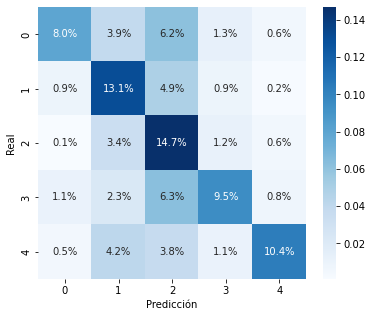

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm=  metrics.confusion_matrix(te_y, y_predict)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Blues')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')
plt.show()

##### Predicciones modelo FastText Descongelado

In [ ]:
y_predictFTDes = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predictFTDes.append(predict(text, model = cnn_FT_descongelado.to("cpu")))

Text(33.0, 0.5, 'Real ')

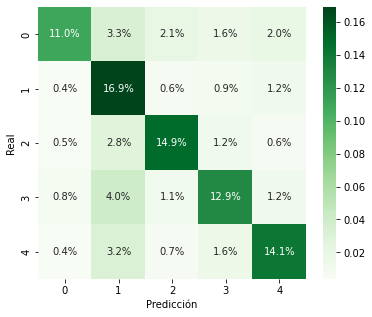

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm =  metrics.confusion_matrix(te_y, y_predictFTDes)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Greens')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')


### Paso 5: Conclusiones

De ambos modelos selecionados, tenemos que ambos tuvieron tiempos de ejecución similares,  (45 segundos aprox). Mientras que en sus errores de entrenamiento y validación el modelo descongelado FastText tuvo una precisión 10% mayor en comparación con el modelo sin transfer learning.
En el momento de realziar la inferencia, estos valores de precisión se mantuvieron similares a los obtenidos en el entrenamiento. Esto fue en parte a que ambos conjuntos de textos se han preprocesado antes de realizar la inferencia, ya que  en experimentos anteriores cuando no preprocese mis documentos de prueba, la presición se vio fuertemente castigada por que habia palabras "no importantes".

#### Comparativa vs los modelos de la tarea 1

Existe una mejora más que buena comparado con los modelos que tomaban la misma capa de embeddings de la tarea 2, donde nunca pudimos superar el 35% de precisión, claramente seña de que las redes convolucionales son una mejora para la clasificación de texto. Sin embargo hubo problemas que no logramos superar, aun nuestro mejor modelo no supero el 80% de precisión tanto en los conjuntos de train/val como en la inferencia del test.

#Problema 3: Borrador


Extraemos lo que requerimos de las reviews (la review, la calificación y la categoria del producto) unicamente de las

In [ ]:
#train=dataset['train'][:'review_body','stars','product_category']
train= df_train.loc[:,['review_body','stars','product_category']]
train_tmp = pd.DataFrame

In [ ]:
categorias = ['home', 'wireless', 'toy', 'sports', 'pc', 'home_improvement', 'electronics']

def select_by_category(dataset_file, category_name):
  data_reducido = dataset_file.loc[:, ['review_body','stars','product_category']]
  data_reducido = data_reducido[data_reducido['product_category']==category_name]
  return (data_reducido)

train_tmp = pd.DataFrame

In [ ]:
t1 = select_by_category(train,categorias[0])
t2 = select_by_category(train,categorias[1])
t3 = select_by_category(train,categorias[2])
t4 = select_by_category(train,categorias[3])
t5 = select_by_category(train,categorias[4])
t6 = select_by_category(train,categorias[5])
t7 = select_by_category(train,categorias[6])

In [ ]:
training=list(t1['review_body'])+list(t2['review_body'])+list(t3['review_body'])+list(t4['review_body'])+list(t5['review_body'])+list(t6['review_body'])+list(t7['review_body'])

In [ ]:
train_clean = pd.concat([t1, t2])
train_clean = pd.concat([train_clean,t3])
train_clean = pd.concat([train_clean,t4])
train_clean = pd.concat([train_clean,t5])
train_clean = pd.concat([train_clean,t6])
train_clean = pd.concat([train_clean,t7])

In [ ]:
print(len(t1)+len(t2)+len(t3)+len(t4)+len(t5)+len(t6)+len(t7))
print(len(training))

112139
112139
112139


Ahora realizamos el cambio de estrellas a negativo (0) y positivo (1)

In [ ]:
def stars_to_sentiment(df_star):
  df = df_star['stars']
  encoded_labels = np.array([1 if label >= 3 else 0 for label in df])
  return encoded_labels

In [ ]:
train_clean['stars'] = stars_to_sentiment(train_clean)

Ahora vuelvo numericas las categorias del producto

In [ ]:
train_clean.product_category = pd.Categorical(train_clean.product_category) #se cambio el tipo de la columna:

In [ ]:
train_clean['product_category'] = train_clean.product_category.cat.codes

In [ ]:
y_train_star = train_clean['stars']
y_train_cat = train_clean['product_category']
X_train = training

In [ ]:
val= df_validation.loc[:,['review_body','stars','product_category']]
val_tmp = pd.DataFrame

In [ ]:
v1 = select_by_category(val,categorias[0])
v2 = select_by_category(val,categorias[1])
v3 = select_by_category(val,categorias[2])
v4 = select_by_category(val,categorias[3])
v5 = select_by_category(val,categorias[4])
v6 = select_by_category(val,categorias[5])
v7 = select_by_category(val,categorias[6])

In [ ]:
val_clean = pd.concat([v1, v2])
val_clean = pd.concat([val_clean,v3])
val_clean = pd.concat([val_clean,v4])
val_clean = pd.concat([val_clean,v5])
val_clean = pd.concat([val_clean,v6])
val_clean = pd.concat([val_clean,v7])

In [ ]:
validation=list(v1['review_body'])+list(v2['review_body'])+list(v3['review_body'])+list(v4['review_body'])+list(v5['review_body'])+list(v6['review_body'])+list(v7['review_body'])

estrellas

In [ ]:
val_clean['stars'] = stars_to_sentiment(val_clean)

categorias

In [ ]:
val_clean.product_category = pd.Categorical(val_clean.product_category) #se cambio el tipo de la columna:
val_clean['product_category'] = val_clean.product_category.cat.codes

Obtenemos el conjunto de validación y sus etiquetas para ambas tareas de clasificación

In [ ]:
y_val_star = val_clean['stars']
y_val_cat  = val_clean['product_category']
X_val      = val_clean['review_body']

In [ ]:
print(len(v1)+len(v2)+len(v3)+len(v4)+len(v5)+len(v6)+len(v7))
print(len(y_val_cat))
print(len(validation))

2817
2817
2817


In [ ]:
texts  = training
labels = y_train_cat

In [ ]:
print( len(training))
print(len(y_train_cat))

112139
112139


# Problema 3: Clasificados de producto y sentimiento para el conjunto "Amazon reviews"

## Paso 0: Descarga y preprocesamiento de los datos

In [ ]:
#pip install datasets

In [ ]:
from datasets import load_dataset, get_dataset_config_names
from IPython.display import display, HTML
dataset_name = "amazon_reviews_multi"
dataset = load_dataset(path=dataset_name, name="es")
print(dataset)
dataset.set_format("pandas")
df = dataset["train"][:]
sample = df.sample(n=8, random_state=42)
display(HTML(sample.to_html()))

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
119737,es_0407390,product_es_0581068,reviewer_es_0240856,3,Mini usb cable de carga defectuoso por lo cual se estropearon los usb de las baterias,El drone funciona a la perfeccion,es,toy
72272,es_0543653,product_es_0928614,reviewer_es_0576116,2,El cable es muy largo y es comodo pero me duró poco tiempo porque el conector microusb se me acabó doblando,Muy Largo,es,wireless
158154,es_0723575,product_es_0453054,reviewer_es_0143292,4,Ideal para mis necesidades.,Práctico,es,home
65426,es_0051657,product_es_0422258,reviewer_es_0046219,2,"Es desigual el color, y mancha. El hilo de rompe con demasiada facilidad y yo creo que viene de menos.","Cómo en Aliexpress, pero más caro",es,home
30074,es_0500242,product_es_0617238,reviewer_es_0557698,1,Los comentarios se hacen cuando uno recibe la mercancía. antes de recibirla es imposible si llega el lunes serán 5 días de retraso,No recibido,es,watch
23677,es_0889640,product_es_0014237,reviewer_es_0537246,1,"Después de estar esperando a que me envíen el producto 1 mes, me indican que no tienen stock y me devuelven el dinero. Y digo yo....si no tienen para que narices lo ponen a la venta? Impresentables estos chinos que por ahorrarnos unos € luego pasa lo que pasa.",IMPRESENTABLES,es,pet_products
134858,es_0354744,product_es_0727645,reviewer_es_0853808,4,"Al parecer es un tratamiento a largo plazo, dos meses descansar uno, o dos y dos. La ingesta de más producto no beneficia más, el organismo lo elimina mediante la orina. Si lleva todo lo que dice, beneficioso será. Yo personalmente he notado mejoría, pero lo cierto es que también he retomado la actividad física (bici y gimnasio) que tenía abandonada hace tiempo, y eso también ayuda a encontrarse mejor. Es mi primer bote y le daré oportunidad. Repetiré. Un saludo!!!",Parece que funciona.,es,drugstore
176418,es_0656835,product_es_0925904,reviewer_es_0636546,5,se adapta a mis necesidades,bien,es,camera


In [ ]:
#Recuperamos los datos de entrenamiento, validacion y prueba
trains=dataset['train'][:]
validation=dataset['validation'][:]
test=dataset['test'][:]

In [ ]:
train1=trains[trains['product_category']=='home']
train2=trains[trains['product_category']=='wireless']
train3=trains[trains['product_category']=='toy']
train4=trains[trains['product_category']=='sports']
train5=trains[trains['product_category']=='pc']
train6=trains[trains['product_category']=='home_improvement']
train7=trains[trains['product_category']=='electronics']

In [ ]:
training=list(train1['review_body'])+list(train2['review_body'])+list(train3['review_body'])+list(train4['review_body'])+list(train5['review_body'])+list(train6['review_body'])+list(train7['review_body'])
labels=list(train1['product_category'])+list(train2['product_category'])+list(train3['product_category'])+list(train4['product_category'])+list(train5['product_category'])+list(train6['product_category'])+list(train7['product_category'])
labels_stars=list(train1["stars"])+list(train2['stars'])+list(train3['stars'])+list(train4['stars'])+list(train5['stars'])+list(train6['stars'])+list(train7['stars'])


In [ ]:
for i in range(len(labels)):
  if(labels[i]=='home'):
    labels[i]=0
  elif(labels[i]=='wireless'):
    labels[i]=1
  elif(labels[i]=='toy'):
    labels[i]=2
  elif(labels[i]=='sports'):
    labels[i]=3
  elif(labels[i]=='pc'):
    labels[i]=4
  elif(labels[i]=='home_improvement'):
    labels[i]=5
  else:
    labels[i]=6

In [ ]:
#labels
labels = labels_stars
for i in range(len(labels_stars)):
  if(labels_stars[i]<=2):
    labels[i]=0
  else:
    labels[i]=1

In [ ]:
stemmer = WordNetLemmatizer()
word_punctuation_tokenizer = nltk.WordPunctTokenizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in es_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

Preprocesamos el texto

In [ ]:
final_corpus = [preprocess_text(document) for document in training if document.strip() !='']

In [ ]:
# Tokenize, build vocabulary, encode tokens
tokenized_texts, word2idx, max_len = tokenize(final_corpus)
input_ids = encode(tokenized_texts, word2idx, max_len)

#### Construccion del DataLoader

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)

In [ ]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =tuple(torch.tensor(data) for data in [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

#### Construccion de los embeddings

FastText

In [ ]:
embeddings_FastText = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/NLP/FastText/embeddings-l-model.vec")
embeddings_FastText = torch.tensor(embeddings_FastText)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 37092 / 39720 pretrained vectors found.


Word2Vecc

In [ ]:
#Word2Vec
embeddings_Word2Vec = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/T3/SBW-vectors-300-min5.txt")
embeddings_Word2Vec = torch.tensor(embeddings_Word2Vec)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 34022 / 39720 pretrained vectors found.


Glove

In [ ]:
#Globe /content/drive/MyDrive/T3/glove-sbwc.i25.vec
embeddings_Glove = load_pretrained_vectors(word2idx, "/content/drive/MyDrive/T3/glove-sbwc.i25.vec")
embeddings_Glove = torch.tensor(embeddings_Glove)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 34952 / 39720 pretrained vectors found.


##Paso 1:Construcción de la CNN para la clasificación de la clase de producto
Usaremos la misma que para el problema 2 ajustada a que ahora son 7 clases (1 para cada tipo de producto)

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=7,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        #self.fc = nn.Linear(num_classes, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=7,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=7,
                        dropout=0.5)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=20):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

##Paso 2: Entrenamiento (Caso Categoria)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

#device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


#### Modelo sin transfer Learning

In [ ]:
set_seed(42)
mod1, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(mod1, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.683589   |  1.550029  |   43.45   |   34.22  
   2    |   1.520343   |  1.474492  |   45.89   |   34.15  
   3    |   1.427103   |  1.440490  |   47.43   |   33.90  
   4    |   1.354967   |  1.432558  |   47.52   |   33.91  
   5    |   1.290863   |  1.435700  |   47.39   |   33.90  
   6    |   1.227921   |  1.429550  |   47.85   |   33.85  
   7    |   1.171367   |  1.448346  |   47.92   |   33.85  
   8    |   1.121909   |  1.465011  |   47.90   |   33.95  
   9    |   1.068376   |  1.485001  |   47.83   |   33.87  
  10    |   1.021372   |  1.505120  |   47.71   |   33.86  
  11    |   0.977672   |  1.531458  |   47.47   |   33.87  
  12    |   0.940607   |  1.564815  |   47.28   |   33.85  
  13    |   0.908345   |  1.590507  |   46.97   |   33.94  
  14    |   0.870148   |  1.629059  |   47.64   |   33.86  
  15    |   0.835280

#### Modelos con FastText

##### Modelo basado en transfer learning con FastText descongelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_FT_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_FastText,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_FT_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.489796   |  1.353129  |   50.21   |   52.75  
   2    |   1.347378   |  1.317835  |   52.00   |   52.60  
   3    |   1.293227   |  1.305331  |   53.06   |   52.69  
   4    |   1.245737   |  1.297544  |   53.63   |   52.56  
   5    |   1.200843   |  1.298299  |   53.27   |   53.44  
   6    |   1.157375   |  1.307080  |   53.10   |   52.64  
   7    |   1.113655   |  1.329693  |   52.77   |   52.58  
   8    |   1.071802   |  1.353212  |   52.52   |   53.37  
   9    |   1.028682   |  1.367087  |   52.58   |   53.66  
  10    |   0.987571   |  1.401631  |   52.24   |   52.74  
  11    |   0.948181   |  1.403521  |   52.09   |   52.82  
  12    |   0.911400   |  1.437350  |   52.20   |   53.16  
  13    |   0.872009   |  1.466445  |   51.72   |   52.62  
  14    |   0.835259   |  1.516142  |   51.77   |   52.82  
  15    |   0.803917

##### Modelo basado en transfer learning con FastText congelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_FT_congelado, optimizer = initilize_model(pretrained_embedding=embeddings_FastText,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_FT_congelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.497985   |  1.363812  |   49.81   |   17.19  
   2    |   1.366226   |  1.336086  |   51.47   |   17.38  
   3    |   1.317418   |  1.320857  |   52.48   |   18.21  
   4    |   1.276891   |  1.317252  |   52.76   |   17.72  
   5    |   1.240366   |  1.315651  |   52.34   |   17.26  
   6    |   1.204118   |  1.317265  |   52.23   |   17.74  
   7    |   1.170544   |  1.333147  |   52.06   |   17.26  
   8    |   1.138870   |  1.358926  |   51.70   |   18.09  
   9    |   1.105635   |  1.350747  |   52.14   |   17.70  
  10    |   1.080070   |  1.382589  |   51.50   |   17.12  
  11    |   1.049613   |  1.383634  |   51.53   |   17.14  
  12    |   1.026519   |  1.391278  |   51.62   |   17.23  
  13    |   0.999112   |  1.413392  |   51.15   |   17.15  
  14    |   0.977150   |  1.432000  |   51.72   |   17.12  
  15    |   0.957232

#### Modelos con Word2Vec

##### Modelo basado en transfer learning con Word2Vec descongelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_W2V_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_Word2Vec,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_W2V_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.607792   |  1.404050  |   47.96   |   52.91  
   2    |   1.367683   |  1.319167  |   52.25   |   53.56  
   3    |   1.290830   |  1.297321  |   53.47   |   53.54  
   4    |   1.237949   |  1.285376  |   53.81   |   52.86  
   5    |   1.190611   |  1.285216  |   53.78   |   53.00  
   6    |   1.140240   |  1.293556  |   53.42   |   53.25  
   7    |   1.093983   |  1.311747  |   53.54   |   54.99  
   8    |   1.041793   |  1.339196  |   53.34   |   53.35  
   9    |   0.988394   |  1.362999  |   53.25   |   53.82  
  10    |   0.933957   |  1.404219  |   52.42   |   54.98  
  11    |   0.880385   |  1.429629  |   51.73   |   52.93  
  12    |   0.825822   |  1.471549  |   52.01   |   53.07  
  13    |   0.772662   |  1.522648  |   51.25   |   53.64  
  14    |   0.723590   |  1.584957  |   51.56   |   53.40  
  15    |   0.678406

##### Modelo basado en transfer learning con Word2Vec congelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_W2V_congelado, optimizer = initilize_model(pretrained_embedding=embeddings_Word2Vec,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_W2V_congelado, optimizer, train_dataloader, val_dataloader, epochs=20)

#### Modelos con Glove

##### Modelo basado en transfer learning con Glove descongelado

In [ ]:
set_seed(42)
cnn_Glove_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_Glove,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_Glove_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

##### Modelo basado en transfer learning con Glove congelado

In [ ]:
set_seed(42)
cnn_Glove_congelado, optimizer = initilize_model(pretrained_embedding=embeddings_Glove,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_Glove_congelado, optimizer, train_dataloader, val_dataloader, epochs=20)

## Paso 3: Evaluación de los mejores modelos

Se obtuvo un resultado similar (en lo que el mejor modelo) fue FastText con la capa de embeddings descongelada. Una observación importante es la siguiente.

Para esta etapa, unicamente haremos la inferencia sobre el modelo sin tansfer learning y con FastText descongelado. Para el analisis de sentimiento ya solo vamos a ejecutar el entrenamiento sobre el modelo sin transfer learning y las variantes de FastText congelada y no.

#### Selección de las reviews de interes

In [ ]:
test1=test[test['product_category']=='home']
test2=test[test['product_category']=='wireless']
test3=test[test['product_category']=='toy']
test4=test[test['product_category']=='sports']
test5=test[test['product_category']=='pc']
test6=test[test['product_category']=='home_improvement']
test7=test[test['product_category']=='electronics']

testing=list(test1['review_body'])+list(test2['review_body'])+list(test3['review_body'])+list(test4['review_body'])+list(test5['review_body'])+list(test6['review_body'])+list(test7['review_body'])
ytest=list(test1['product_category'])+list(test2['product_category'])+list(test3['product_category'])+list(test4['product_category'])+list(test5['product_category'])+list(test6['product_category'])+list(test7['product_category'])


#### Preprocesamos las reviews de test

In [ ]:
final_corpus_test = [preprocess_text(document) for document in testing if document.strip() !='']


##### Predicciones del modelo s/Transfer Learning

In [ ]:
y_predict = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predict.append(predict(text, model = mod1.to("cpu")))

In [ ]:
for i in range(len(ytest)):
  if(ytest[i]=='home'):
    ytest[i]=0
  elif(ytest[i]=='wireless'):
    ytest[i]=1
  elif(ytest[i]=='toy'):
    ytest[i]=2
  elif(ytest[i]=='sports'):
    ytest[i]=3
  elif(ytest[i]=='pc'):
    ytest[i]=4
  elif(ytest[i]=='home_improvement'):
    ytest[i]=5
  else:
    ytest[i]=6

##### Evaluación del modelo s/Transfer Learning

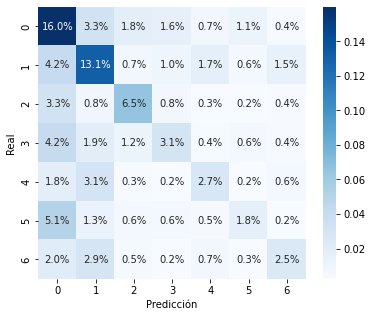

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm=  metrics.confusion_matrix(ytest, y_predict)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Blues')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')
plt.show()

In [ ]:
y_predictFTDes = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predictFTDes.append(predict(text, model = cnn_FT_descongelado.to("cpu")))

##### Predicciones del modelo FastText

Text(33.0, 0.5, 'Real ')

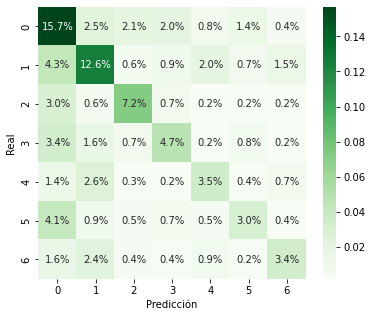

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm =  metrics.confusion_matrix(ytest, y_predictFTDes)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Greens')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')

## Conclusiones

Aqui tenemos el problema de que son muchos más datos. Los tiepos de ejecución fueron mas altos, incluso la version Colab Pro tuvo algunos problemas de ejecución a las cuestiones de GPU.
En terminos de la calidad de los modelos, Nuevamente FastText es el modelo de embedding que mejores resultados obutvo, algo que llamo la antención fue que los modelos de Glove tuvieron menores resultados que el modelo sin transfer learning.

Aun así ningun modelo supero el 60%.

##  Paso 2: Entrenamiento (Caso Sentimiento)

Aquí se repite lo del caso anterior pero con unicamente 2 categorias (de sentimiento positivo o negativo).

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

### Construccion de la CNN

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        #self.fc = nn.Linear(num_classes, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### Evaluación del modelo

Como hemos tenido buenos resultados con FastText, es el unico modelo de transfer learning que tome a consideración ademas del modelo sin TL.

#### Modelo sin transfer Learning

In [ ]:
set_seed(42)
mod1, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(mod1, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.516244   |  0.466082  |   77.56   |   39.52  
   2    |   0.444720   |  0.449217  |   78.70   |   33.99  
   3    |   0.407117   |  0.445383  |   79.13   |   34.23  
   4    |   0.375755   |  0.450591  |   79.13   |   34.84  
   5    |   0.348670   |  0.463180  |   79.08   |   36.68  
   6    |   0.318908   |  0.468384  |   79.14   |   35.06  
   7    |   0.295297   |  0.480966  |   78.89   |   34.44  
   8    |   0.272039   |  0.499160  |   78.99   |   34.66  
   9    |   0.250602   |  0.524363  |   78.95   |   34.50  
  10    |   0.232577   |  0.538359  |   79.10   |   34.42  
  11    |   0.216028   |  0.553155  |   78.94   |   34.74  
  12    |   0.199846   |  0.576829  |   78.88   |   34.48  
  13    |   0.187332   |  0.603406  |   78.94   |   35.00  
  14    |   0.178141   |  0.607537  |   78.90   |   34.34  
  15    |   0.166811

#### Modelo  con FastText como embedding con fine tunning Descongelado

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training. SGD optmin
set_seed(42)
cnn_FT_descongelado, optimizer = initilize_model(pretrained_embedding=embeddings_FastText,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_FT_descongelado, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.463188   |  0.434264  |   79.76   |   54.71  
   2    |   0.411769   |  0.425857  |   80.47   |   54.04  
   3    |   0.387369   |  0.431063  |   80.52   |   53.50  
   4    |   0.363889   |  0.424258  |   80.72   |   53.46  
   5    |   0.341547   |  0.460436  |   79.44   |   53.41  
   6    |   0.316252   |  0.441578  |   80.69   |   53.38  
   7    |   0.293843   |  0.481892  |   79.84   |   53.31  
   8    |   0.272534   |  0.494410  |   79.69   |   53.37  
   9    |   0.250953   |  0.527407  |   79.30   |   53.37  
  10    |   0.230859   |  0.516687  |   79.94   |   53.41  
  11    |   0.212545   |  0.558824  |   79.93   |   53.38  
  12    |   0.197862   |  0.578689  |   80.03   |   53.35  
  13    |   0.183301   |  0.590458  |   79.70   |   53.30  
  14    |   0.172599   |  0.611843  |   79.92   |   53.29  
  15    |   0.160166

### Seleccion de reviews texts y preprocesamiento

In [ ]:
test1=test[test['product_category']=='home']
test2=test[test['product_category']=='wireless']
test3=test[test['product_category']=='toy']
test4=test[test['product_category']=='sports']
test5=test[test['product_category']=='pc']
test6=test[test['product_category']=='home_improvement']
test7=test[test['product_category']=='electronics']

testing=list(test1['review_body'])+list(test2['review_body'])+list(test3['review_body'])+list(test4['review_body'])+list(test5['review_body'])+list(test6['review_body'])+list(test7['review_body'])
ytest=list(test1['stars'])+list(test2['stars'])+list(test3['stars'])+list(test4['stars'])+list(test5['stars'])+list(test6['stars'])+list(test7['stars'])


In [ ]:
final_corpus_test = [preprocess_text(document) for document in testing if document.strip() !='']


In [ ]:
y_star = ytest
for i in range(len(ytest)):
  if(ytest[i]<=2):
    y_star[i]=0
  else:
    y_star[i]=1

In [ ]:
def predict(text, model=mod1.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    return(torch.argmax(probs).numpy())

### Predicciones de los modelos

Se esperaba que al ser menos categorias, tuviera mejores precisiones (basicamente un mal modelo aquí seria un bolado).

#### Modelo sin transfer learning

In [ ]:
y_predict = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predict.append(predict(text, model = mod1.to("cpu")))

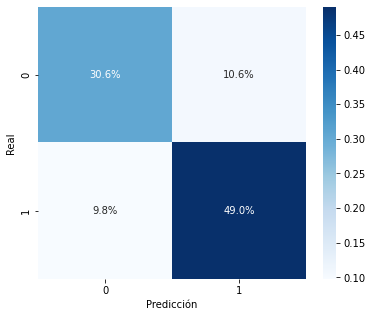

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm=  metrics.confusion_matrix(ytest, y_predict)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Blues')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')
plt.show()

#### Predicciones c/Modelo FasText descongelado

In [ ]:
y_predictFTDes = []
for id_text in range(len(final_corpus_test)):
  text = final_corpus_test[id_text]
  y_predictFTDes.append(predict(text, model = cnn_FT_descongelado.to("cpu")))

Text(33.0, 0.5, 'Real ')

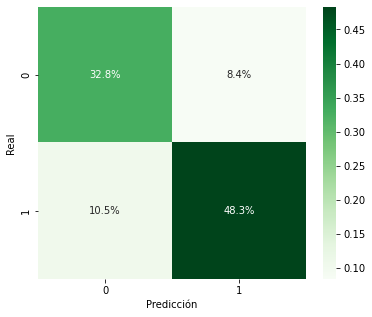

In [ ]:
plt.rcParams["figure.figsize"] = (6,5)
prom_svm =  metrics.confusion_matrix(ytest, y_predictFTDes)
ax = sns.heatmap(prom_svm/np.sum(prom_svm), annot=True, fmt='0.1%', cmap='Greens')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real ')

##  Conclusiones

Al ser un modelo de clasificación binario, se esperaba que tuviera altos indices de precisión y fue así, en el conjunto de entrenamiento/valudación su Presicion rondo el 80%.

Sin embargo fue el modelo que más tiempo llevo para ejecutarse, pues para 20 epocas tardaba casi 20 minutos.

#Referencias

Me base en las notas del profesos, sus funciones de preprocesamiento, mientras que la implementación de la red neuronal provienen del trabajo de Cristian Tran.

[A Complete Guide to CNN for Sentence Classification with PyTorch](https://chriskhanhtran.github.io/posts/cnn-sentence-classification/)